# Sensor Fault Detection
The inputs of various sensors for different wafers have been provided. In electronics, a wafer (also called a slice or substrate) is a thin slice of semiconductor used for the fabrication of integrated circuits. The goal is to build a machine learning model which predicts whether a wafer needs to be replaced or not(i.e., whether it is working or not) based on the inputs from various sensors. There are two classes: +1 and -1.

    •	+1 means that the wafer is in a working condition and it doesn’t need to be replaced.
    •	-1 means that the wafer is faulty and it needs to be replaced. 



#### Import the required libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics 
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
# from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
# from catboost import CatBoostClassifier
# from imblearn.combine import SMOTETomek
import glob
import os
warnings.filterwarnings("ignore")
%matplotlib inline

#### Load Data

In [2]:
flage = 0
path = "wafer\\data_ingestion\\Training_raw_files_validated\\Good_Raw"

for f in os.listdir(path):
    temp = pd.read_csv(path+'\\'+f)

    if flage == 0:
        flage=1
        data = temp
    else:
        data = data.append(temp)

In [3]:
data.shape

(837, 592)

In [4]:
print("Number of features: ", data.shape[1])
print("Unique features: ", data['Good/Bad'].unique())
print("Number of features: "+str(data['Good/Bad'].nunique()) + ", It's binary classification")
print("Class distribution: \n", data['Good/Bad'].value_counts(), " it's perfectly imbalance classification")

Number of features:  592
Unique features:  [-1  1]
Number of features: 2, It's binary classification
Class distribution: 
 -1    800
 1     37
Name: Good/Bad, dtype: int64  it's perfectly imbalance classification


#### Categorical and numerical feature count

In [5]:
print("Numerical feature count: ",len([f for f in data.columns if data[f].dtypes != 'O']))
print("Numerical feature: ",[f for f in data.columns if data[f].dtypes != 'O'])


Numerical feature count:  591
Numerical feature:  ['Sensor-1', 'Sensor-2', 'Sensor-3', 'Sensor-4', 'Sensor-5', 'Sensor-6', 'Sensor-7', 'Sensor-8', 'Sensor-9', 'Sensor-10', 'Sensor-11', 'Sensor-12', 'Sensor-13', 'Sensor-14', 'Sensor-15', 'Sensor-16', 'Sensor-17', 'Sensor-18', 'Sensor-19', 'Sensor-20', 'Sensor-21', 'Sensor-22', 'Sensor-23', 'Sensor-24', 'Sensor-25', 'Sensor-26', 'Sensor-27', 'Sensor-28', 'Sensor-29', 'Sensor-30', 'Sensor-31', 'Sensor-32', 'Sensor-33', 'Sensor-34', 'Sensor-35', 'Sensor-36', 'Sensor-37', 'Sensor-38', 'Sensor-39', 'Sensor-40', 'Sensor-41', 'Sensor-42', 'Sensor-43', 'Sensor-44', 'Sensor-45', 'Sensor-46', 'Sensor-47', 'Sensor-48', 'Sensor-49', 'Sensor-50', 'Sensor-51', 'Sensor-52', 'Sensor-53', 'Sensor-54', 'Sensor-55', 'Sensor-56', 'Sensor-57', 'Sensor-58', 'Sensor-59', 'Sensor-60', 'Sensor-61', 'Sensor-62', 'Sensor-63', 'Sensor-64', 'Sensor-65', 'Sensor-66', 'Sensor-67', 'Sensor-68', 'Sensor-69', 'Sensor-70', 'Sensor-71', 'Sensor-72', 'Sensor-73', 'Sensor-7

In [6]:
print("Count of numerical features: ", len([f for f in data.columns if data[f].dtypes == 'O']))
print("Numerical features: ", [f for f in data.columns if data[f].dtypes == 'O'])

Count of numerical features:  1
Numerical features:  ['Wafer']


In [7]:
wafer_name = data['Wafer'].nunique()
data.drop(['Wafer'], axis=1, inplace=True)

### As this is sensor data, interpretation of data is not required

#### Checking missing values

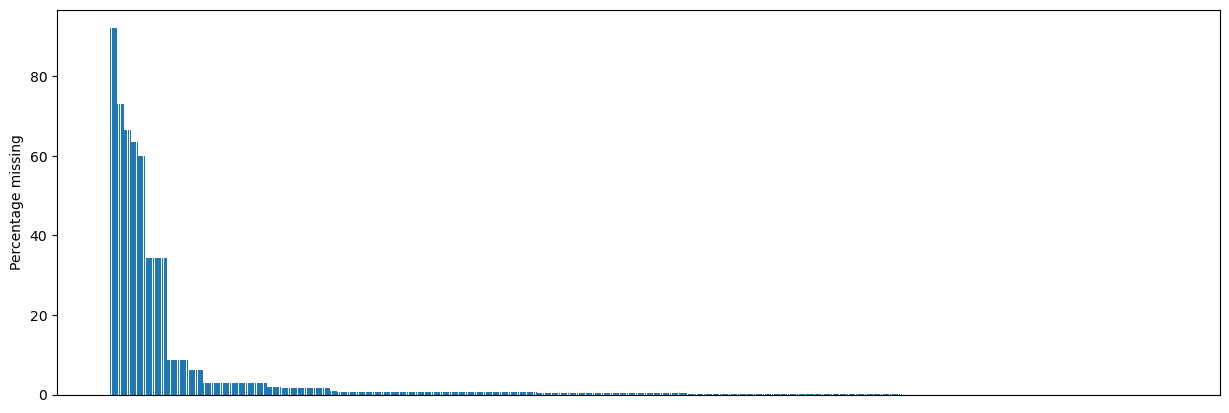

In [8]:
# Plotting Missing values count for each column
fig, ax = plt.subplots(figsize=(15,5))

missing = data.isna().sum().div(data.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

#### Droping columns which has >70% missing values

In [9]:
dropcols = missing[missing[0] > 70]
dropcols

,0
Sensor-294,92.114695
Sensor-158,92.114695
Sensor-159,92.114695
Sensor-293,92.114695
Sensor-221,72.998805
Sensor-359,72.998805
Sensor-86,72.998805
Sensor-493,72.998805


In [10]:
data.drop(list(dropcols.index), axis=1, inplace=True)

#### Check the percentage os missing values after droping features with more than 70% missing values

In [11]:
missing_values_count = data.isna().sum()
total_cells = np.product(data.shape)
total_missing_values = missing_values_count.sum()
print(f"Percentage of total missing cells in the data {round((total_missing_values/total_cells) * 100,2)}%")

Percentage of total missing cells in the data 2.76%


#### Visualization of unique values in label feature

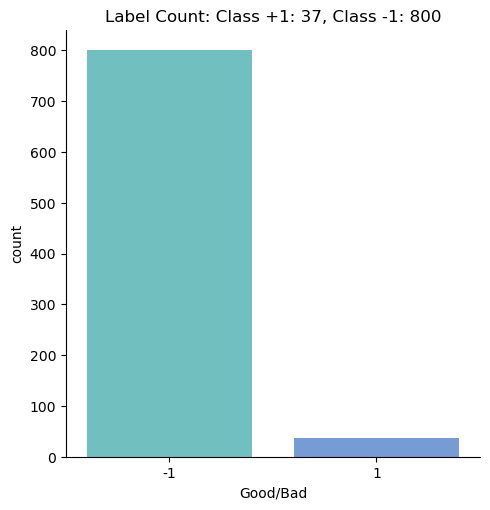

In [12]:
pos = data[data['Good/Bad']==+1].shape[0]
neg = data[data['Good/Bad']==-1].shape[0]
sns.catplot(data=data, x="Good/Bad", kind="count", palette="winter_r", alpha=.6)
plt.title("Label Count: Class +1: {v1}, Class -1: {v2}".format(v1=pos, v2=neg))
plt.show()

#### Report

- The target classes are highly imbalanced
- Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative class (majority class) very large compared to that of the positive class (minority class)
- If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model.
    Hence we should handle imbalanced data with certain methods.

#### How to handle Imbalance Data ?

- Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information.
- SMOTE: Synthetic Minority Oversampling Technique SMOTE is an oversampling technique where the synthetic samples are generated for the minority class.
- Hybridization techniques involve combining both undersampling and oversampling techniques. This is done to optimize the performance of classifier models for the samples created as part of these techniques.
- It only duplicates the data and it won't add and new information. Hence we look at some different techniques.

#### Create Functions for model training and evaluation

In [13]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [14]:
# Create cost of the model as per data description
def total_cost(y_true, y_pred):
    '''
    This function takes y_ture, y_predicted, and prints Total cost due to misclassification
   
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost

In [15]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    cost_list=[]
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
        
    return report

#### Plot distribution of all independent numerical features

In [16]:
# numeric_features = [feature for feature in data.columns if data[feature].dtype != 'O']

# plt.figure(figsize=(15, 100))
# for i, col in enumerate(numeric_features):
#     plt.subplot(60, 3, i+1)
#     sns.distplot(x=data[col], color='indianred')
#     plt.xlabel(col, weight='bold')
#     plt.tight_layout()

#### Report

- As per the above plot most of the features are not normally distributed.
- Transformation of data is not of prime importance since it is a classification problem.
- Interpreting each and every column is not necessary as this is sensor data.

#### Evaluate models based on experiments

In [17]:
X = data.drop("Good/Bad", axis=1)
y = data['Good/Bad']

#### Manually encode label feature

In [18]:
y= y.replace({-1: 0})

## Experiment: 1 - KNN Imputer for NULL values

#### Why Robust scaler and not Standard scaler?

- Scaling the data using Robust scaler
- Since most of the independent variables are not normally distributed we cannot use Standardscaler

#### Why Robust Scaler and not Minmax?

- Because most of the feature has outliers. So Minmax will scale data according to Max values which is outlier.
- This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [19]:
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

#### Why KNN Imputer?

- KNNImputer by scikit-learn is a widely used method to impute missing values. It is widely being observed as a replacement for traditional imputation techniques.
- KNNImputer helps to impute missing values present in the observations by finding the nearest neighbors with the Euclidean distance matrix.
- Here we Iterates through different K values and get accuracy and choose best K values.

#### Finding the optimal n_neighbour value for KNN imputer

In [20]:
results=[]
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(scores)
    print('n_neighbors= %s || accuracy (%.4f)' % (s , mean(scores)))

n_neighbors= 1 || accuracy (0.9176)
n_neighbors= 3 || accuracy (0.9080)
n_neighbors= 5 || accuracy (0.9283)
n_neighbors= 7 || accuracy (0.9271)
n_neighbors= 9 || accuracy (0.9068)


#### We can observe n_neighbors=3 able to produce highest accuracy

#### Pipeline for KNN imputer

In [21]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the KNN imputer with selected K-value
knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('RobustScaler', RobustScaler())
])

In [22]:
X_knn =knn_pipeline.fit_transform(X)

### Handling Imbalanced data
- SMOTE+TOMEK is one of such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space.

- This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class

#### To add new data of minority class

- Choose random data from the minority class.
- Calculate the distance between the random data and its k nearest neighbors.
- Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
- Repeat step number 2–3 until the desired proportion of minority class is met.
- To remove the tomek links of the majority class
- Choose random data from the majority class.
- If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.
- This is method instead of adding duplicate data it synthesises the new data based on the already avalialble classes. Hence we choose this as our imputer method for this problem.

In [23]:

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)

smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)

# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_knn, y)

NameError: name 'SMOTETomek' is not defined

#### Initialize Default Models in a dictionary

In [ ]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

#### Fit KNN imputed data for models in dictionary

In [ ]:
report_knn = evaluate_models(X_res, y_res, models)


### Report for KNN Imputed data

In [ ]:
report_knn

#### Insights

- For the Experiment 1: Knn imputer has XGBoost classifier as the best Model
- Proceeding with further experiments

### Experiment: 2 = Simple Imputer with Strategy Median
- SimpleImputer is a class in the sklearn.impute module that can be used to replace missing values in a dataset, using a variety of input strategies.
- Here we use SimpleImputer can also be used to impute multiple columns at once by passing in a list of column names. SimpleImputer will then replace missing values in all of the specified columns.

In [ ]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the Simple imputer with strategy median
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [ ]:
# Fit X with median_pipeline
X_median = median_pipeline.fit_transform(X)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority')
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_median, y)

In [ ]:
# Training the models
report_median = evaluate_models(X_res, y_res, models)

#### Report for Simple Imputer with median strategy

In [ ]:
report_median

### Insights

- For the Experiment 2: Simple imputer with median strategy has Catboost classifier as the best Model
- Proceeding with further experiments

### Report for MICE Imputer algorithm
- MICE stands for Multivariate Imputation By Chained Equations algorithm
- This technique by which we can effortlessly impute missing values in a dataset by looking at data from other columns and - trying to estimate the best prediction for each missing value.
- ImputationKernel Creates a kernel dataset. This dataset can perform MICE on itself, and impute new data from models obtained during MICE.

In [ ]:
import miceforest as mf

X_mice = X.copy()
kernel = mf.ImputationKernel(
  X_mice,
  save_all_iterations=True,
  random_state=1989
)# Run the MICE algorithm for 3 iterations kernel.mice(3)

In [ ]:
X_mice = kernel.complete_data()

In [ ]:
# fit robust scaler
mice_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])

In [ ]:
# Fit X with Mice imputer 
X_mice= mice_pipeline.fit_transform(X_mice)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mice, y)

In [ ]:
# Training the models
report_mice = evaluate_models(X_res, y_res, models)

### Report for MICE Imputer algorithm

In [ ]:
report_mice

### Insights

- For the Experiment 3: Mice imputer has XGBoost classifier as the best Model
- Proceeding with further experiments

## Experiment: 4 = Simple Imputer with Strategy Constant
- Another strategy which can be used is replacing missing values with a fixed (constant) value.
- To do this, specify “constant” for strategy and specify the fill value using the fill_value parameter

In [ ]:
# Create a pipeline with simple imputer with strategy constant and fill value 0
constant_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [ ]:
X_const =constant_pipeline.fit_transform(X)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const, y)

In [ ]:
# training the models
report_const = evaluate_models(X_res, y_res, models)

### Report for Simple Imputer with Constant strategy

In [ ]:
report_const

### Insights

- For the Experiment 4: Simple imputer with constant strategy has XGBoost classifier as the best Model
- Proceeding with further experiments

## Experiment: 5 = Simple Imputer with Strategy Mean
- Another strategy which can be used is replacing missing values with mean
- Here we replace the missing values with the mean of the column

In [ ]:
# Create a pipeline with Simple imputer with strategy mean
mean_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='mean')),
    ('RobustScaler', RobustScaler())
])

In [ ]:
X_mean = mean_pipeline.fit_transform(X)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority' , n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mean, y)

In [ ]:
# Training all models
report_mean = evaluate_models(X_res, y_res, models)

### Report for Simple imputer with strategy mean

In [ ]:
report_mean

## Experiment: 5 = Principle component analysis with imputing median
- Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables!
- As the dataset has 164 columns we can try PCA and check our metrics Cost

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [ ]:
#Applying PCA
from sklearn.decomposition import PCA
var_ratio={}
for n in range(2,150):
    pc=PCA(n_components=n)
    df_pca=pc.fit(X_pca)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)

#### Variance Plot

In [ ]:
# plotting variance ratio
pd.Series(var_ratio).plot()

#### Kneed algorithm to find the elbow point

In [ ]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio= list(var_ratio.values())
components=  list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= components[knee.knee]
print('Knee Locator k =', k)

In [ ]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=18,random_state=42).fit(X_res)

reduced=pca_final.fit_transform(X_pca)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(reduced, y)

In [ ]:
# Training all models
report_pca = evaluate_models(X_res,y_res, models)

## Report for PCA and Mean imputed data

In [ ]:
report_pca

# Final Model

In [ ]:
from prettytable import PrettyTable

pt=PrettyTable()
pt.field_names=["Model","Imputation_method","Total_cost"]
pt.add_row(["XGBClassifier","Simple Imputer-Constant","2950"])
pt.add_row(["XGBClassifier","Mice","3510"])
pt.add_row(["XGBClassifier","Knn-Imputer","4460"])
pt.add_row(["XGBClassifier","Simple Imputer-Mean","4950"])
pt.add_row(["CatBoostClassifier","Median","5760"])
pt.add_row(["Random Forest","PCA","34150"])
print(pt)

#### Report

- From the final report we can see than XGBClassifier with Simple imputer with strategy constant has performed the best with cost of 2950

#### Fitting the Final model and get reports

In [ ]:
final_model = XGBClassifier()

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

final_model = final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [ ]:
print("Final XGBoost Classifier Accuracy Score (Train) :", final_model.score(X_train,y_train))
print("Final XGBoost Classifier Accuracy Score (Test) :", accuracy_score(y_pred,y_test))

In [ ]:
print("Final XGBoost Classifier Cost Metric(Test) :",total_cost(y_test, y_pred))

In [ ]:
from sklearn.metrics import plot_confusion_matrix

#plots Confusion matrix
plot_confusion_matrix(final_model, X_test, y_test, cmap='Blues', values_format='d')